In [ ]:
from sklearn.datasets import fetch_olivetti_faces
data_o = fetch_olivetti_faces()

In [ ]:
X, y = data_o.data, data_o.target
X.shape, y.shape

((400, 4096), (400,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, stratify=y_test, random_state=42)

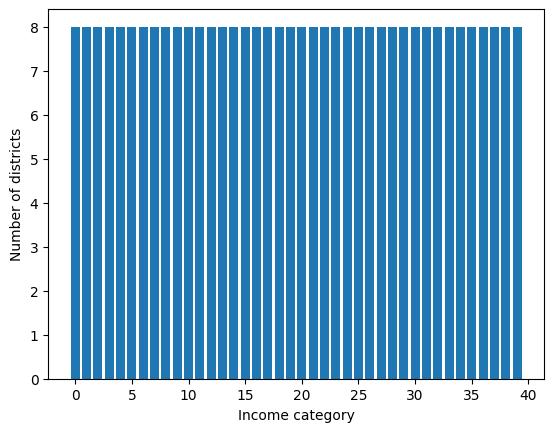

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
from sklearn.cluster import KMeans

kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_train)
                for k in range(40, 150, 5)]

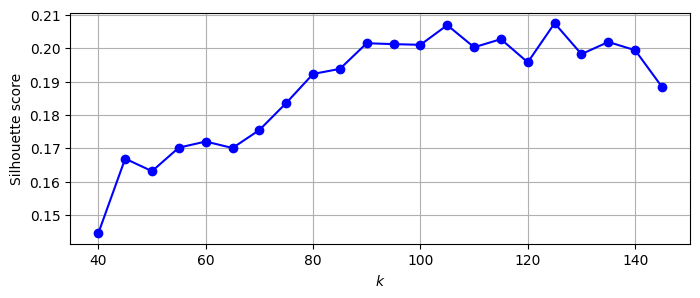

In [ ]:

from sklearn.metrics import silhouette_score


# extra code – this cell generates and saves Figure 9–9

silhouette_scores = [silhouette_score(X_train, model.labels_)
                     for model in kmeans_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(40, 150, 5), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
#plt.axis([1.8, 8.5, 0.55, 0.7])
plt.grid()
plt.show()

In [ ]:
best_cluster = range(40, 150, 5)[np.argmax(silhouette_scores)]
print(f"Best cluster: {best_cluster}")

Best cluster: 125


In [ ]:
kmeans_cl = KMeans(n_clusters=best_cluster, random_state=42)
y_pred = kmeans_cl.fit_predict(X_train)
y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([ 33,  59,  61, 100,  15,  23,  60,  44,  54,  65,  97, 110,   8,
        22,  79,   8,  44, 117,  17,  37,  85,  37,  42, 124,  16,  20,
        76,  11,  29,  33,  89,  28,  50,   5,  46,  77,  94,  58,  66,
        91,  50, 102,  61,  55,  45,  45,   3,  65,  28,   7,  27,  72,
        70,  25,  37,  48,  34, 106,  23,  44,  23, 120,  61,  56,  62,
         0,  84,  92,  26, 104,  48,  62,  83,  22,  26, 112, 101,  15,
        21,  10,  81,  60,  51,  35,   7, 117,  20,  83,  73,  81,   1,
        66,  76,  96,  26,  39,  71, 120,  79,  60,  98,  47,  69,  31,
        21,  78,  47,  49,   2,  25,   8,  25,  25,   5,  71,  53,  85,
        25,  74,  88,   0,   7, 117,  78,  99, 114, 112,  45,  17,  23,
         0,  63,  40,  35,  62,  36,  52,  49,  33,   7,  78,   2, 123,
        64,  15,  34,  49,   1, 112,  36,  53,  27,  70,  70,  39,  94,
        46,  97,  24,  64,  36,  30,  26, 121,  63,  22,  43,  58,  12,
        57,  82,  60,  87,  25,  36,  53,  25,  31,  27,  97,  3

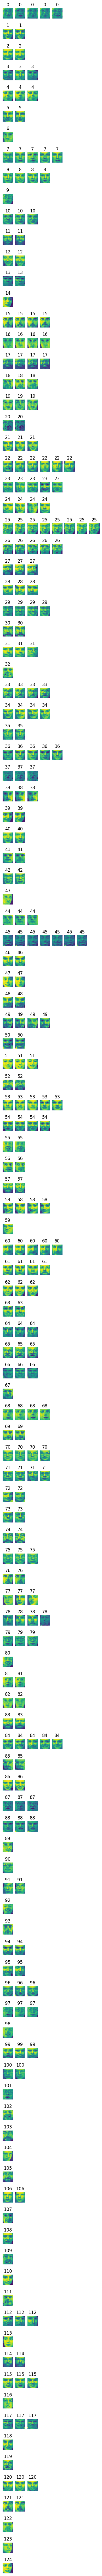

In [ ]:
pred_yX_sorted = zip(y_pred.tolist(), X_train)
sorted_clusters = sorted(pred_yX_sorted, key=lambda x:x[0])

plt.figure(figsize=(6, 128))

index = 0
last_label = 0
row_index = 0
for item in sorted_clusters:
  if last_label != item[0]:
    row_index+=1
    index = 0
  plt.subplot(best_cluster, 10, 10* row_index + index + 1)
  plt.title(f"{item[0]}")
  plt.imshow(item[1].reshape(64, 64))
  plt.axis('off')
  index +=1
  last_label = item[0]

In [ ]:
kmeans_cl_test = KMeans(n_clusters=105, random_state=42)

X_faces_dist = kmeans_cl_test.fit_transform(X_train)
representative_faces_idx = np.argmin(X_faces_dist, axis=0)
X_representative_faces = X_train[representative_faces_idx]
y_representative_faces = y_train[representative_faces_idx]
representative_faces_idx.shape, X_faces_dist.shape

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


((105,), (320, 105))

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_faces, y_representative_faces)
log_reg.score(X_val, y_val)

0.925

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
  ("kmeans_dim_red", KMeans(random_state=42, n_init=10)),
  ("logistic_regression", LogisticRegression(max_iter=10_000)),
])
param_grid = [{'kmeans_dim_red__n_clusters': range(40, 150, 5)}]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans_dim_red',
                                        KMeans(n_init=10, random_state=42)),
                                       ('logistic_regression',
                                        LogisticRegression(max_iter=10000))]),
             param_grid=[{'kmeans_dim_red__n_clusters': range(40, 150, 5)}],
             scoring='neg_root_mean_squared_error')

In [ ]:
grid_search.best_estimator_.score(X_val, y_val)

0.95

In [ ]:
log_reg_compare = LogisticRegression(max_iter=10_000)
log_reg_compare.fit(X_train, y_train)
log_reg_compare.score(X_val, y_val)

0.975

In [ ]:
np.concatenate((X_train, grid_search.best_estimator_["kmeans_dim_red"].transform(X_train)), axis=1).shape

In [ ]:
#X_transformed
added = np.concatenate((X_train, grid_search.best_estimator_["kmeans_dim_red"].transform(X_train)), axis=1)

log_test = LogisticRegression(max_iter=10_000)

log_test.fit(added, y_train)
log_test.score(np.concatenate((X_val, grid_search.best_estimator_["kmeans_dim_red"].transform(X_val)), axis=1), y_val)

0.95

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
X_reduced = pca.fit_transform(X_train)

gm = GaussianMixture(n_components=40, n_init=10, random_state=42)
gm.fit(X_reduced)

GaussianMixture(n_components=40, n_init=10, random_state=42)

In [ ]:
pca.n_components_


222

In [ ]:
pca.inverse_transform(gm.sample()[0])

array([[0.20114534, 0.53128452, 0.88314128, ..., 0.18074346, 0.1066627 ,
        0.08755344]])

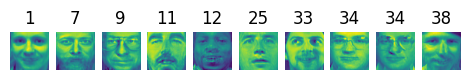

In [ ]:
saved_imgs = []

for i in range(10):
  plt.subplot(1, 11, i + 1)
  plt.title(f"{gm.sample(n_samples=10)[1][i]}")
  img = pca.inverse_transform(gm.sample(n_samples=10)[0][i]).reshape(64, 64)
  saved_imgs.append(img)
  plt.imshow(img)
  plt.axis('off')

In [ ]:
theta = 45
rot_mat = np.array([[-np.sin(theta), 0],
                    [0, -np.cos(theta)]])


(array([ 23,  82, 101, 106, 222, 255, 265, 293]),)

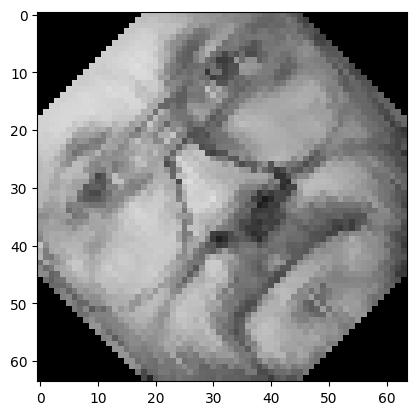

In [ ]:
from PIL import Image
img_aug = Image.fromarray(X_train[0].reshape(64, 64)*256)
plt.imshow(img_aug.rotate(45))

np.where(y_train == 7)

In [ ]:
densities = gm.score_samples(pca.transform(X_train[:10]))
density_threshold = np.percentile(densities, 2)
anomalies = X_train[:10][densities < density_threshold]
anomalies.shape

(1, 4096)

In [ ]:

X_train_copy = np.array(X_train, copy=True)[:10]
X_train_copy[2] = np.array(Image.fromarray(X_train_copy[2].reshape(64, 64) *256).rotate(45)).reshape(4096) /256

X_train_copy[9] = np.array(Image.fromarray(X_train_copy[9].reshape(64, 64) *256).rotate(90)).reshape(4096)/256

X_train_copy[0] = np.array(Image.fromarray((X_train_copy[9] - 0.1).reshape(64, 64)  *256)).reshape(4096)/256

densities1 = gm.score_samples(pca.transform(X_train_copy))
density_threshold1 = np.percentile(densities1, 2)
anomalies1 = X_train_copy[densities1 < density_threshold]
print(anomalies1, densities1 < density_threshold)

[[0.35041323 0.35454547 0.36694217 ... 0.0570248  0.0570248  0.05289256]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.28512397 0.28512397 0.27272728 ... 0.30165288 0.30991736 0.3140496 ]
 [0.45041323 0.45454547 0.46694216 ... 0.1570248  0.1570248  0.15289256]] [ True False  True  True False False False False False  True]


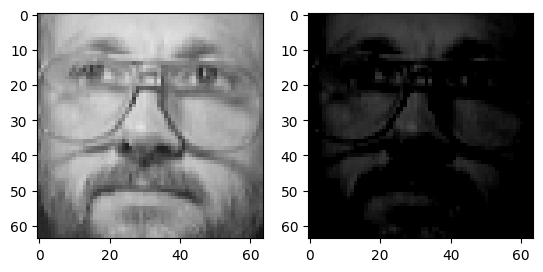

In [ ]:
from PIL import Image
X_train_copy = np.array(X_train, copy=True)[:10]
img_aug = Image.fromarray((X_train_copy[9] - 0.6).reshape(64, 64)  *256)
plt.subplot(1, 2, 2)
plt.imshow(img_aug)
img_aug = Image.fromarray((X_train_copy[9]).reshape(64, 64)  *256)
plt.subplot(1, 2, 1)
plt.imshow(img_aug)


In [ ]:
from sklearn.metrics import mean_squared_error

pca_oliv = PCA(n_components=0.99)
X_train_transformed_pca = pca_oliv.fit_transform(X_train)
rec = pca_oliv.inverse_transform(X_train_transformed_pca)
mean_squared_error(X_train, rec)

0.00018999894